In [1]:
import jax.numpy as jnp
from jax import random
from melvin.maximum_likelihood import MaximumLikelihoodModel
from jax.experimental.optimizers import adam, sgd
import jax
import matplotlib.pylab as plt
from functools import partial

In [1]:
from jax.scipy.optimize import minimize

In [2]:
SEED = random.PRNGKey(123068)
N_ROWS = 2000
LATENT_MEAN = 2.0
LATENT_STD = 3.0
NOISE_STD = 2.0

In [3]:
SEED, _seed_1, _seed_2 = random.split(SEED,3)
y_latent = jax.random.normal(key=_seed_1, shape=(N_ROWS,))*LATENT_STD + LATENT_MEAN
y = y_latent + jax.random.normal(key=_seed_1, shape=(N_ROWS,))*NOISE_STD

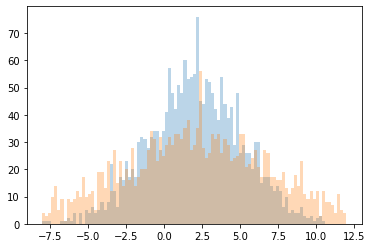

In [4]:
bins = jnp.linspace(-8,12,100)
plt.hist(y_latent, bins=bins, alpha=0.3)
plt.hist(y, bins=bins, alpha=0.3)
plt.show()

In [14]:
@jax.jit
def model_fn(params, X, fixed_params):
    mu = params[0]
    std_latent = jnp.exp(params[1])
    std_noise = fixed_params[0]
    std = jnp.sqrt(std_latent**2 + std_noise**2)
    return jnp.array([mu, std])

@jax.jit
def log_likelihood_fn(y, y_pred, params, fixed_params):
    mu = y_pred[0]
    std = y_pred[1]
    log_like = jax.scipy.stats.norm.logpdf(y, loc=mu, scale=std)
    return jnp.sum(log_like)

SEED, _seed = random.split(SEED)
initial_params = jax.random.normal(key=_seed, shape=(2,))

gaussian_density_estimator = MaximumLikelihoodModel(
    name="Gaussian Density Estimator",
    model_fn=model_fn,
    log_likelihood_fn=log_likelihood_fn,
    initial_params=initial_params,
    fixed_params=jnp.array([NOISE_STD]),
    optimizer=adam,
    optimizer_kwargs={"step_size": 0.001}
)

gaussian_density_estimator.fit(n_steps=5000, X=None, y=y)

Gaussian Density Estimator:  60%|██████    | 3010/5000 [00:51<00:33, 58.82it/s]


KeyboardInterrupt: 

<AxesSubplot:title={'center':'History'}, xlabel='Iteration', ylabel='Loss'>

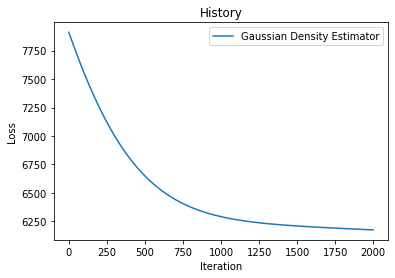

In [6]:
gaussian_density_estimator.plot_history()

In [11]:
fitted_params = model_fn(gaussian_density_estimator.params, None, jnp.array([0.0]))
print(f"\nFitted parameters\n{fitted_params}")


Fitted parameters
[0.5087991 4.9091043]


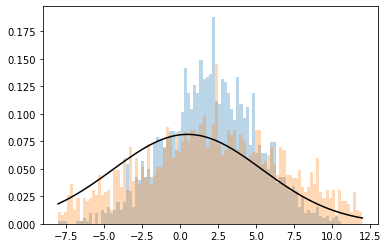

In [13]:
x = jnp.linspace(-8,12,100)
mu = gaussian_density_estimator.params[0]
std_latent = jnp.exp(gaussian_density_estimator.params[1])
y_pdf = jax.scipy.stats.norm.pdf(x, loc=fitted_params[0], scale=fitted_params[1])
plt.hist(y_latent, bins=x, alpha=0.3, density=True)
plt.hist(y, bins=x, alpha=0.3, density=True)
plt.plot(x, y_pdf, color="k")
plt.show()